# Name: Prashant Pandey                                Student ID: 16200112

## Part1  Scrape Web Page

In [1]:
import urllib.request
import requests
import nltk
import os.path
import numpy as np
import pandas as pd
import nltk
import glob
import re
import os
from bs4 import BeautifulSoup
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
URL="http://mlg.ucd.ie/modules/COMP41680/news/"

In [2]:
#get requested page
def getData(url):
    response = urllib.request.urlopen(url) 
    page = response.read().decode("utf-8") 
    response.close()
    return page

In [3]:
#This method returns all titles of new docs
def get_titles(url):
    html_page=getData(url)
    bs_parser = BeautifulSoup(html_page,"html.parser") #Parse the html Page to retrieve all the tags  
    titles=[]
    for match in bs_parser.find_all("a",href=lambda x: x and x.startswith('article')):  #select title where href starts with article
        text = match.get_text()
        titles.append(text)
    return titles

In [4]:
#fetch all the link of a url
def fetch_links(url):
    html=getData(url)  #retrive page 
    llist=parse_page(html) #get all the links present in the page
    return llist

In [5]:
#get the text in the url
def fetch_text(url):
    html=getData(url)
    parser = BeautifulSoup(html,"html.parser") 
    for m in parser.find_all("div", { "class" : "main" }):  # class main contains the text in a document 
        para = m.get_text()
    return para

In [6]:
#Return links for a html page
def parse_page(html):
    alllinks=set()
    parser = BeautifulSoup(html,"html.parser") #Parse the html Page to retrieve all the tags  
    for link in parser.findAll('a'):  #find all anchor tags
        link=link.get('href') #fetch link in the anchor 
        if(link!=""):  #if link is not present don't add it
            alllinks.add(URL+link) #add the complete url's
    return alllinks

In [7]:
doc_titles=[]  # to get titles of all docs
pages=fetch_links(URL)  #get all pages in the base (main) page
alllinks=set()  # make global link set to retrieve sub links of a link
for link in pages:  # for each link in a webpage
    doc_titles.extend(get_titles(link))
    alllinks.update(fetch_links(link))   # add it to the global link set
pages=pages.union(alllinks)  # update page list
for link in alllinks:
    filename=link.split("/")[-1][:-5]  #get fifth token which is name of the article
    if not os.path.exists(filename):   # write if file is not present
        file = open(filename,'w') 
        file.write(fetch_text(link))
        file.close()

## Part2  Clustering  and Topic modeling

### Text preprocessing

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# define the function for lemmatization
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens=[]
    for token in tokens:
        if re.search('[a-zA-Z]', token):  # save those which are non-numeric
            lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

In [9]:
docs_text=[]  #store text of all documents
for files in glob.glob('*'): #all files in the present directory
    if(files.startswith('article')): #only select file which starts with 'article'
        handle = open(files,'r')
        docs_text.append(handle.read())  
        handle.close()

### tf-idf

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
#chosen n-gram of three words. It will produce phrases containing upto three words
vectorizer = TfidfVectorizer(min_df=5,stop_words='english',tokenizer=lemma_tokenizer, ngram_range=(1,3)) 
#fit the vectorizer to documents
tfidf_matrix = vectorizer.fit_transform(docs_text) 

In [14]:
terms = vectorizer.get_feature_names()
feature_array = np.array(terms)
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
n = 30
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

  (0, 8636)	0.10644077314
  (0, 5953)	0.0553604956408
  (0, 6288)	0.138394786116
  (0, 2605)	0.085159196573
  (0, 3216)	0.0694980023021
  (0, 3090)	0.110049899176
  (0, 1431)	0.13364716227
  (0, 5445)	0.103527150537
  (0, 8019)	0.0705543807571
  (0, 8154)	0.105783545449
  (0, 5754)	0.127585860505
  (0, 6155)	0.0495513565443
  (0, 6814)	0.0380612533767
  (0, 8769)	0.0276789572231
  (0, 8226)	0.0494216077514
  (0, 9076)	0.0203260561726
  (0, 3009)	0.0267781517702
  (0, 2732)	0.084505484465
  (0, 8505)	0.0459956208488
  (0, 7249)	0.0838439637861
  (0, 7429)	0.0516444145086
  (0, 3397)	0.310860394174
  (0, 6693)	0.449864145143
  (0, 3278)	0.0856526084347
  (0, 2669)	0.0432999355443
  :	:
  (1130, 2546)	0.154296995554
  (1130, 5849)	0.118653938766
  (1130, 2549)	0.0325879018296
  (1130, 5850)	0.0377278775252
  (1130, 726)	0.0739626501481
  (1130, 6747)	0.0369813250741
  (1130, 5716)	0.0739626501481
  (1130, 8333)	0.0385742488886
  (1130, 6287)	0.0377278775252
  (1130, 5720)	0.0385742488886


The most charasterisitic terms and phrases for the corpus are 'mobile', 'tv','music','broadcasting','handset','video','europe','battery life', 'gartner' and 'music download service'. Hence most documents are related to digital technology, gartner music which are from europe.

#### K Means Clustering

In [13]:
from sklearn.cluster import KMeans  #find best K by reducing within cluster sum of squares measure
import matplotlib.pyplot as plt

num_clusters = range(1,8)  #test for K 1 to 8 clusters to get best cluster
KM = [KMeans(n_clusters=k).fit(tfidf_matrix) for k in num_clusters]  #fit the Kmeans to the tf-idf
centroids = [k.cluster_centers_ for k in KM]  #get all centroids

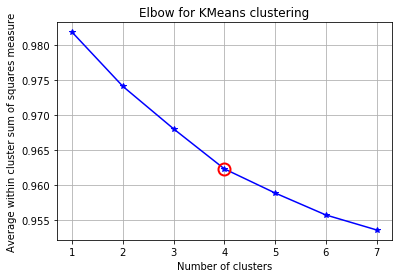

In [14]:
%matplotlib inline
from scipy.spatial.distance import cdist

D_k = [cdist(tfidf_matrix.toarray(), cent,'euclidean') for cent in centroids]  #euclidean as a distance measure
eucldist = [np.min(D,axis=1) for D in D_k]  #find minimum distance
avgWithinSM = [sum(d)/tfidf_matrix.shape[0] for d in eucldist]
kIdx = 3
# plot elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(num_clusters, avgWithinSM, 'b*-')
ax.plot(num_clusters[kIdx], avgWithinSM[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within cluster sum of squares measure')
plt.title('Elbow for KMeans clustering')

Relatively sharp elbow is at k=4, so selecting it as best K for this problem.

In [15]:
from sklearn.cluster import KMeans
best_K=4
model = KMeans(best_K)  
model.fit(tfidf_matrix)  #fit kmeans for k=4
clusters = model.labels_.tolist()
news = {'docs': docs_text,'cluster': clusters}  #create dictionary of docs and cluster
frame = pd.DataFrame(news, index = [clusters] , columns = ['cluster'])  #this frame will help in cross-tabulation

In [16]:
print('Number of documents per cluster')
frame['cluster'].value_counts()   #get total document count grouped in each cluster

Number of documents per cluster


3    333
2    296
0    276
1    226
Name: cluster, dtype: int64

In [17]:
totalvocab_lemmetized = []  #holds lemmetized tokens for all docs
for i in docs_text:
    allwords_lemmetized = lemma_tokenizer(i)   
    totalvocab_lemmetized.extend(allwords_lemmetized)  
#dataframe of lemmetized tokens. This will get to find most frequent words in a cluster
vocab_frame = pd.DataFrame({'words': totalvocab_lemmetized}, index = totalvocab_lemmetized)

### Frequent words in clusters

In [18]:
print("Top terms per cluster:")
print()
l=['first','second','third','fourth']
#sort cluster centers by proximity to centroid
order_centroids = model.cluster_centers_.argsort()[:, ::-1] 

for i in range(best_K):
    print(l[i],"Cluster top words:", end='')
    for ind in order_centroids[i, :10]: #top 10 words per cluster
        word=vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        print(' %s' % word, end=',')
    print()
    print()

Top terms per cluster:

first Cluster top words: game, club, nan, player, wa, goal, arsenal, united, league, ha,

second Cluster top words: hospital, health, nan, child, patient, said, wa, doctor, medical, nan,

third Cluster top words: mobile, phone, said, people, technology, user, music, computer, digital, ha,

fourth Cluster top words: cent, nan, tax, bank, irish, said, year, economy, rate, government,



This is really nice clustering. Very clearly, we get clusters of documents related to 'Health','Sports','Digital Technology' and'Economy'. These are the topics or theme of each of the four clusters.

In [19]:
indexlist=[]   #get list to plot legends
legendlist=[]
legendlist.append('Digital Technology')
indices = [p for p, s in enumerate(docs_text) if 'mobile' in s]   #find doc index where mobile is present
indexlist.append(model.labels_[indices[0]])      
legendlist.append('Health')
indices = [p for p, s in enumerate(docs_text) if 'hospital' in s] #find doc index where hospital is present
indexlist.append(model.labels_[indices[0]])
legendlist.append('Economy')
indices = [p for p, s in enumerate(docs_text) if 'cent' in s]  #find doc index where cent is present
indexlist.append(model.labels_[indices[0]])
legendlist.append('Sports')
indices = [p for p, s in enumerate(docs_text) if 'game' in s]  #find doc index where game is present
indexlist.append(model.labels_[indices[0]])

### Vizualization of K-Means clusters using Principal Component analysis

When data is high-dimensional, it is not possible to plot it using normal techniques of scatter plot. PCA is used to get the two most representative features of the data and plot according to them. Here features are the terms in the document.

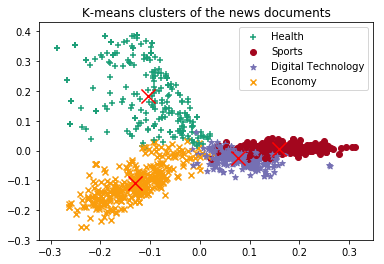

In [20]:
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(tfidf_matrix.todense())  #convert sparse tf-idf to dense form
data2D = pca.transform(tfidf_matrix.todense())  # get 2-D representation


for i in range(0, data2D.shape[0]):  #plot PCA
    if model.labels_[i] == 1:
        c1 = plt.scatter(data2D[i,0],data2D[i,1],c='#1b9e77', marker='+')
    elif model.labels_[i] == 0:
        c2 = plt.scatter(data2D[i,0],data2D[i,1],c='#a3061e',marker='o')
    elif model.labels_[i] == 2:
        c3 = plt.scatter(data2D[i,0],data2D[i,1],c='#7570b3',marker='*')
    elif model.labels_[i] == 3:
        c4 = plt.scatter(data2D[i,0],data2D[i,1],c='#f99d0c',marker='x')
pl.legend([c1, c2, c3,c4],[legendlist[indexlist.index(1)],legendlist[indexlist.index(0)],legendlist[indexlist.index(2)],legendlist[indexlist.index(3)]])
pl.title('K-means clusters of the news documents')
    
centers2D = pca.transform(model.cluster_centers_)   #locate means
plt.scatter(centers2D[:,0], centers2D[:,1], 
           marker='x', s=200, linewidths=3, c='r')

## Hierarchical Clustering

Clustering the data using hierarchical clustering with the ward's method.

Ward's minimum variance criterion minimizes the total within-cluster variance. To implement this method, at each step find the pair of clusters that leads to minimum increase in total within-cluster variance after merging. This increase is a weighted squared distance between cluster centers. At the initial step, all clusters are singletons (clusters containing a single point). To apply a recursive algorithm under this objective function, the initial distance between individual objects must be (proportional to) squared distance metric used.

Ward's method is the closest, by it properties and efficiency, to K-means clustering,hence it is chosen over single, complete and average linkage hierarchical clustering.

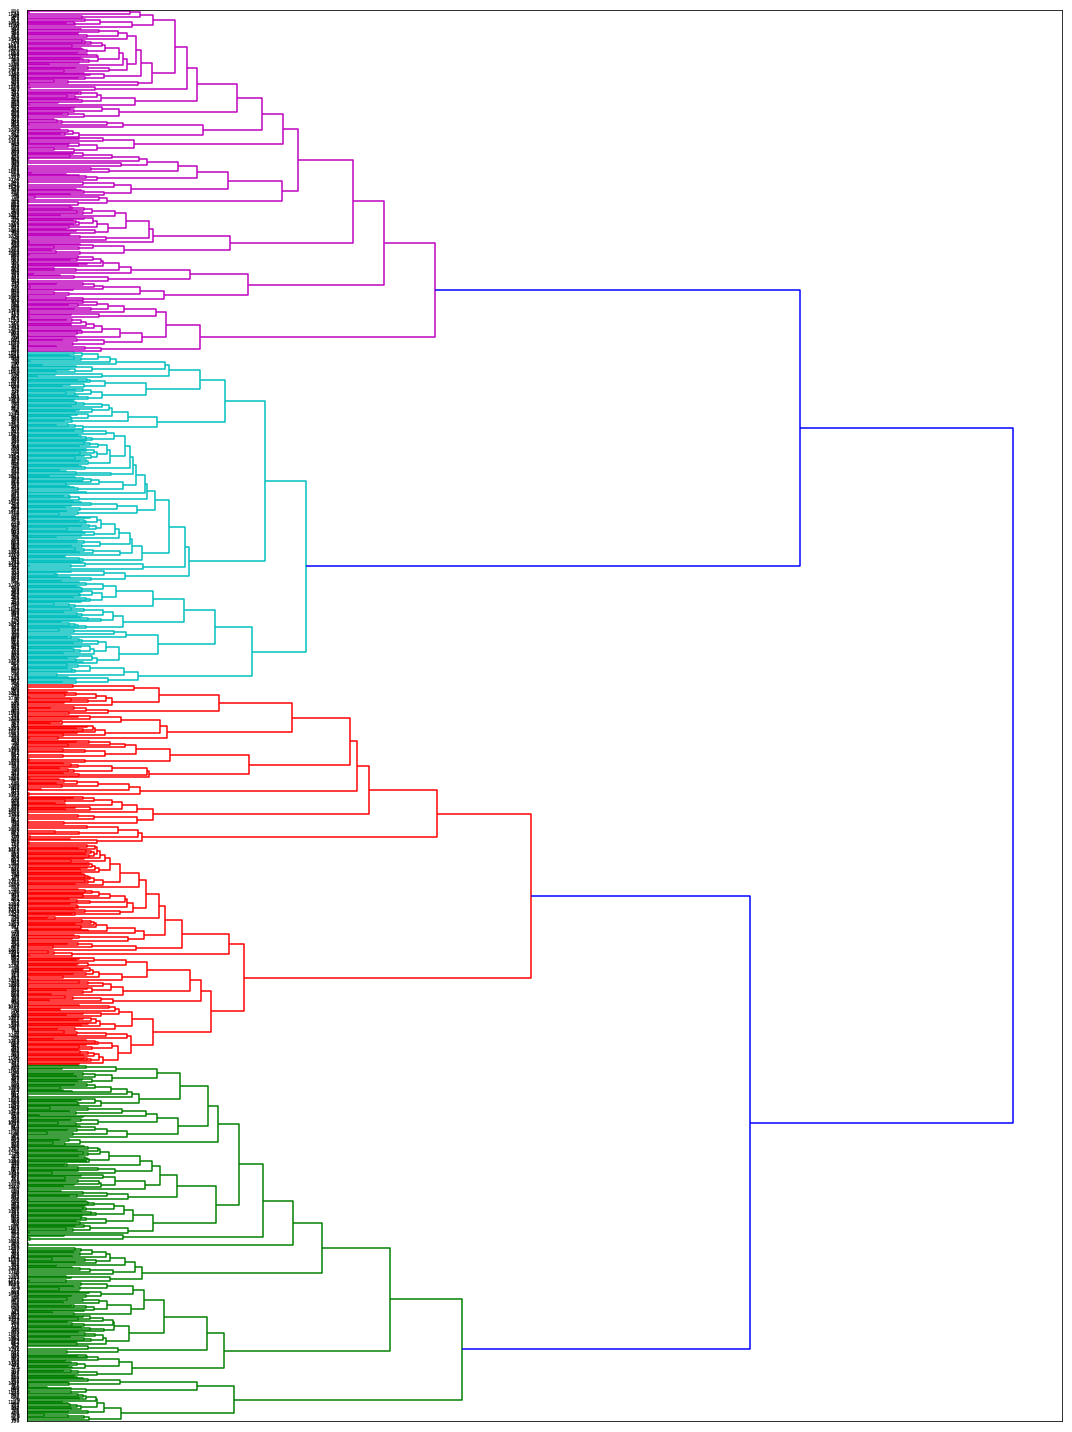

In [21]:
from scipy.cluster.hierarchy import ward,dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)   #using cosine distance
linkage_matrix = ward(dist)   #get linkage matrix using ward's method

fig, ax = plt.subplots(figsize=(15, 20)) # set size 
ax = dendrogram(linkage_matrix, orientation="right")   #get the dendrogram

plt.tick_params(   #set tick parameters
    axis= 'x',          
    which='both',     
    bottom='off',      
    top='off',        
    labelbottom='off')

plt.tight_layout() 

Dendrogram clearly shows 4 possible clusters. These are produced by cutting it across the lines with largest unvarying height. 

In [22]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
# cut-off the tree to leave 4 clusters
clustering = fcluster(linkage_matrix,4,'maxclust')
print('Number of documents per cluster')
x = np.array(clustering)
unique, counts = np.unique(clustering, return_counts=True)
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)

Number of documents per cluster
[[  1 286]
 [  2 305]
 [  3 266]
 [  4 274]]


### Frequent words in clusters

In [23]:
import pandas as pd
top_n=10
X = pd.DataFrame(tfidf_matrix.toarray())  
X['cluster'] = clustering  #labels from hierarchical clustering
word_frequencies_by_cluster = X.groupby('cluster').sum()
df=pd.DataFrame({n: word_frequencies_by_cluster.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(word_frequencies_by_cluster.T)}).T    
print("Top terms per cluster:")
print()
l=['first','second','third','fourth']

for i in range(best_K):
    print(l[i],"Cluster top words:", end='')
    for ind in df[i::10]: #top 10 words per cluster
        word=vocab_frame.ix[terms[df.ix[i,ind]].split(' ')].values.tolist()[0][0]
        print(' %s' % word, end=',')
    print()
    print()


Top terms per cluster:

first Cluster top words: cent, tax, nan, bank, economy, said, irish, rate, year, government,

second Cluster top words: hospital, health, nan, child, said, patient, wa, medical, doctor, year,

third Cluster top words: game, club, nan, player, wa, goal, arsenal, united, league, ha,

fourth Cluster top words: mobile, phone, people, said, technology, game, user, music, digital, net,



Very clearly, we get clusters of documents related to 'Health','Sports','Digital Technology' and'Economy'. These are the topics or theme of each of the four clusters.

In [24]:
indexlist=[]   #get list to plot legends
legendlist=[]
legendlist.append('Digital Technology')
indices = [p for p, s in enumerate(docs_text) if 'mobile' in s]   #find most frequent label for mobile
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))      
legendlist.append('Health')
indices = [p for p, s in enumerate(docs_text) if 'hospital' in s] #find most frequent label for hospital
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))  
legendlist.append('Economy')
indices = [p for p, s in enumerate(docs_text) if 'cent' in s]  #find most frequent label for cent
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))  
legendlist.append('Sports')
indices = [p for p, s in enumerate(docs_text) if 'game' in s]  #find most frequent label for game
a = np.array(clustering[indices])
counts = np.bincount(a)
indexlist.append(np.argmax(counts))  

### Vizualization of Hierarchical clustering using Principal Component analysis

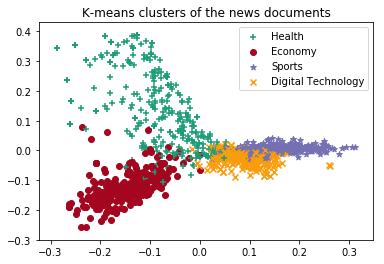

In [25]:
# again use PCA to plot clusters generated using hierarchical clustering
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(tfidf_matrix.todense())
data2D = pca.transform(tfidf_matrix.todense())

for i in range(0, data2D.shape[0]):
    if clustering[i] == 2:
        c1 = plt.scatter(data2D[i,0],data2D[i,1],c='#1b9e77', marker='+')
    elif clustering[i] == 1:
        c2 = plt.scatter(data2D[i,0],data2D[i,1],c='#a3061e',marker='o')
    elif clustering[i] == 3:
        c3 = plt.scatter(data2D[i,0],data2D[i,1],c='#7570b3',marker='*')
    elif clustering[i] == 4:
        c4 = plt.scatter(data2D[i,0],data2D[i,1],c='#f99d0c',marker='x')
pl.legend([c1, c2, c3,c4],[legendlist[indexlist.index(2)],legendlist[indexlist.index(1)],legendlist[indexlist.index(3)],legendlist[indexlist.index(4)]])
pl.title('K-means clusters of the news documents')

# Topics

Latent Dirichlet Allocation (LDA) is used to discover the topics that are present in a corpus. Non-negative Matrix Factorization (NMF), can also be used to find topics in text. The mathematical basis underpinning NMF is quite different from LDA.NMF sometimes produces more meaningful topics for smaller datasets.

Both algorithms are able to return the documents that belong to a topic in a corpus and the words that belong to a topic. LDA is based on probabilistic graphical modeling while NMF relies on linear algebra. Both algorithms take as input a bag of words matrix (i.e., each document represented as a row, with each columns containing the count of words in the corpus). The aim of each algorithm is then to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words matrix with the lowest error.

Both NMF and LDA are not able to automatically determine the number of topics and this must be specified. I have used NMF as dataset is not quite big.

In [26]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

#function displays top words for a Topic
def display_topics(model, feature_names, no_top_words):
    s=","
    for topic_index, topic in enumerate(model.components_):
        print ("Keywords of topic %d:" % (topic_index))
        print (s.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
no_topics = 4  #four is selected as there are four clusters
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)
no_top_words = 10
display_topics(nmf, terms, no_top_words)

Keywords of topic 0:
cent,tax,ireland,bank,irish,rate,year,said,economy,government
Keywords of topic 1:
game,chelsea,club,player,wa,league,arsenal,goal,united,liverpool
Keywords of topic 2:
hospital,health,hse,patient,child,service,doctor,medical,said,wa
Keywords of topic 3:
mobile,phone,technology,people,music,said,digital,service,tv,user


Clearly documents related to 'Health','Sports','Digital Technology' and'Economy'. These are the four topics or theme of each of the four clusters.